# Introduction
In this notebook I will be creating a neural network model that predicts the presence or absence of cardiovascular disease dependent on various factors. The goal is to practice making an effecitve neural network model. The data I will use is from DrivenData.com and is used for an introductory data science competition on there website. The data can also be found on the UCI machine learning repository. I will use the data from DrivenData.com so that I can evaluate my model's performance using a test set I don't have access to. Before creating the models I will perform some explanatory data analysis and discuss the problem to be solved in more detail. 


### Provided data documentation

This database contains 13 attributes (which have been extracted from
a larger set of 75)       
  
#### Attribute Information
1. age       
2. sex       
3. chest pain type  (4 values)       
4. resting blood pressure  
5. serum cholestoral in mg/dl      
6. fasting blood sugar > 120 mg/dl       
7. resting electrocardiographic results  (values 0,1,2) 
8. maximum heart rate achieved  
9. exercise induced angina    
10. oldpeak = ST depression induced by exercise relative to rest   
11. the slope of the peak exercise ST segment     
12. number of major vessels (0-3) colored by flourosopy        
13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
      
#### Attributes Types
- Real: 1,4,5,8,10,12 </br>
- Ordered:11,
- Binary: 2,6,9
- Nominal:7,3,13

#### Variable to be predicted
Absence (1) or presence (2) of heart disease

#### Costs
- True Positive Cost = 0
- True Negative Cost = 0
- False Positive Cost = -1
- False Negative Cost = -5

| Cost      | Absence           | Presence  |
| ------------- |:-------------:| -----:|
| Absence     | 0 | -1 |
| Presence      | -5      |  0|

 
There are 270 observations with no missing values.

One thing to note is that these observations are presumably people who go to a healthcare facility with some cardiovascular issue (each observation for example includes some type of chest pain). So we are trying to distinguish the presence of heart disease from cases in which some other health issue is present.

In [1]:
#Import Packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

#Import Data
df_values = pd.read_csv('train_values.csv', index_col=0)
df_labels = pd.read_csv('train_labels.csv', index_col=0)
df_test_values = pd.read_csv('test_values.csv', index_col=0)

#Lists of Categorical and Numerical features
cat_var = ['sex', 'chest_pain_type', 'thal', 'slope_of_peak_exercise_st_segment', 'num_major_vessels', 'resting_ekg_results', 'exercise_induced_angina']
cont_var = ['resting_blood_pressure','fasting_blood_sugar_gt_120_mg_per_dl','serum_cholesterol_mg_per_dl','oldpeak_eq_st_depression','age','max_heart_rate_achieved']

#Create a dataframe with both features and target variable
df = pd.concat([df_values, df_labels], axis=1)


# Check distribution of target variable in data
print(df['heart_disease_present'].value_counts())

0    100
1     80
Name: heart_disease_present, dtype: int64


In [2]:
# First Look
df.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


# Exploratory Data Analysis
 
After loading the labeled data, we can observe that 80 observations are cases in which heart disease is present and 100 observations are cases in which heart disease is absent.

To get a sense of what features might be predictive I'll do some exploratory analysis of the data. I will use some automated feature selection techniques later, but the exploratory analysis will help me get a feel for the data and any issues there might be for using it to create a predictive model. One potential issue is that there are several categorical variables with multiple levels that will need to be split up into binary variables. Given that there are not many observations to work with, I am concerned about having too many features. For example, there are four types of chest pain. But, binary variables will work better with the model since the model could infer there is a scale present among the four types of chest pain when there is not (in this case there may actually be a scale, but since it is not stated in the documentation we shouldn't assume that there is). We can just replace this feature with a few binary variables, e.g. 'chest pain type one present', but if there is a way to do it without introducing more features than necessary we should find it. I expect we will find some sparse categories so hopefully we will find a sensible way to combine them.  

First I plot the counts of the categorical variables against the target variable so we can see which variables will be predictive and how we might go about creating binary variables from them for modeling.

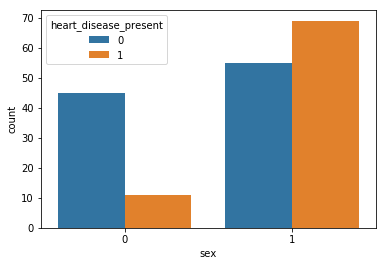

In [3]:
sns.countplot(x='sex', hue='heart_disease_present', data=df)

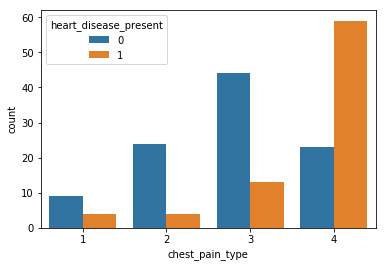

In [4]:
sns.countplot(x='chest_pain_type', hue='heart_disease_present', data=df)

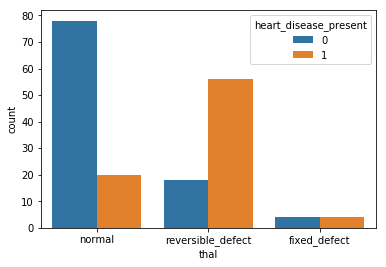

In [5]:
sns.countplot(x='thal', hue='heart_disease_present', data=df)

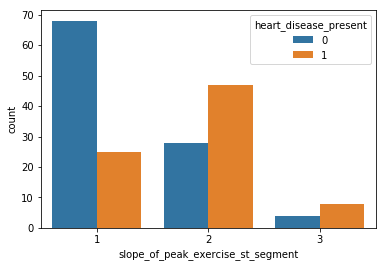

In [6]:
sns.countplot(x='slope_of_peak_exercise_st_segment', hue='heart_disease_present', data=df)

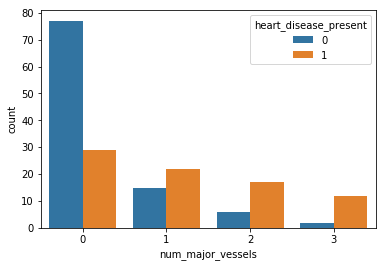

In [7]:
sns.countplot(x='num_major_vessels', hue='heart_disease_present', data=df)

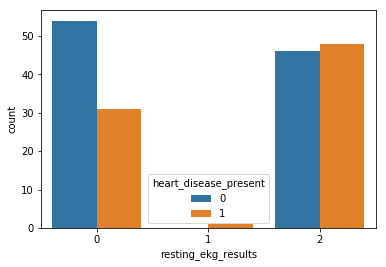

In [8]:
sns.countplot(x='resting_ekg_results', hue='heart_disease_present', data=df)

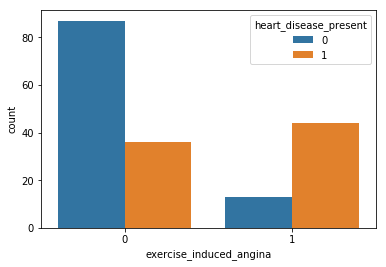

In [9]:
sns.countplot(x='exercise_induced_angina', hue='heart_disease_present', data=df)

As we can see in the above charts, there are several categories that are sparse, e.g. 'fixed defect' in the 'thal' column is only present for a handful of observations. So it should help the modelling if we can do something to effectively get rid of this category. Now let's take a look a couple numeric features. 

C:\Users\jpkel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


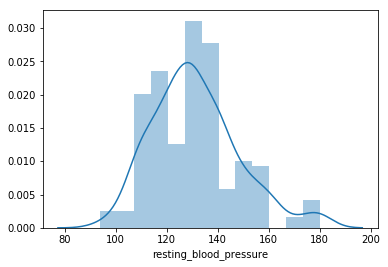

In [10]:
sns.distplot(df['resting_blood_pressure'])

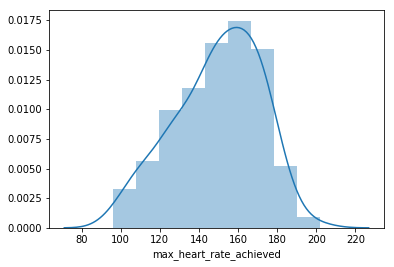

In [11]:
sns.distplot(df['max_heart_rate_achieved'])

The resting blood pressure has an interesting distribution. One thing that could be interesting to do is to convert it into an ordinal feature. We would lose some of the fine-grained detail but it might make it an easier feature for the machine learning algorithms to work with (this is something I'll have to do some research on). 

# Feature Engineering

In this section, we will use what we learned during EDA to create better features for the model. 

First lets address the chest pain type feature. We saw above that chest pain type 4 is indicative of the presence of heart disease while the other types are indicative of the absence of heart disease. So we can create a new feature called chest pain type 4 which just records for each observation whether chest pain type 4 is present or not. We will treat the other categorical variables similarly. Below you can see the results in the dataframe 'df_new_cat_var'.

In [12]:
#Manual Feature Engineering
df_manual_features = pd.read_csv('train_values.csv', index_col=0)
df_test_manual_features = pd.read_csv('test_values.csv', index_col=0)

pain_map = {1:0, 2:0, 3:0, 4:1} 
df_manual_features['chest_pain_type_4'] = df_values['chest_pain_type'].map(pain_map) 
df_test_manual_features['chest_pain_type_4'] = df_test_values['chest_pain_type'].map(pain_map)

thal_map = {'normal':0, 'reversible_defect':1, 'fixed_defect':0}
df_manual_features['thal_reversible'] = df_values['thal'].map(thal_map)
df_test_manual_features['thal_reversible'] = df_test_values['thal'].map(thal_map)

slope_map = {3:1, 2:1, 1:0}
df_manual_features['slope_high'] = df_values['slope_of_peak_exercise_st_segment'].map(slope_map)
df_test_manual_features['slope_high'] = df_test_values['slope_of_peak_exercise_st_segment'].map(slope_map)

vessel_map = {3:1, 2:1, 1:1, 0:0}
df_manual_features['vessel_high'] = df_values['num_major_vessels'].map(vessel_map)
df_test_manual_features['vessel_high'] = df_test_values['num_major_vessels'].map(vessel_map)

resting_map = {0:1, 1:0, 2:0}
df_manual_features['resting_low'] = df_values['resting_ekg_results'].map(vessel_map)
df_test_manual_features['resting_low'] = df_test_values['resting_ekg_results'].map(vessel_map)

df_manual_features.drop(columns=['chest_pain_type', 'thal', 'slope_of_peak_exercise_st_segment', 'num_major_vessels', 'resting_ekg_results'], inplace=True)
df_test_manual_features.drop(columns=['chest_pain_type', 'thal', 'slope_of_peak_exercise_st_segment', 'num_major_vessels', 'resting_ekg_results'], inplace=True)



Now I will try some automated feature selection techniques.

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k_best = SelectKBest(f_classif, k='all')
k_best.fit_transform(df_manual_features, df_labels)
p_values = pd.DataFrame({'column':df_manual_features.columns, 'p_value':k_best.pvalues_}).sort_values('p_value')
display(p_values)

C:\Users\jpkel\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,column,p_value
9,thal_reversible,3.787200e-14
8,chest_pain_type_4,4.111484e-13
7,exercise_induced_angina,2.679484e-10
11,vessel_high,9.514609e-09
3,oldpeak_eq_st_depression,1.124371e-07
6,max_heart_rate_achieved,2.081706e-07
10,slope_high,4.556177e-07
4,sex,4.167617e-06
12,resting_low,4.194226e-02
5,age,6.419006e-02


This is the resulting p-values from an ANOVA. We can see that a few of the features have high p-values.

In [14]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
X = df_manual_features
y = df_labels.values
tree.fit(X,y)
tree_importances = pd.DataFrame({'importance':tree.feature_importances_,'feature':X.columns}).sort_values('importance',ascending=False)
#display(importances)
tree_features = tree_importances[tree_importances['importance']>0.05].feature.values
tree_feautres = list(tree_features)
tree_features

array(['thal_reversible', 'max_heart_rate_achieved', 'chest_pain_type_4',
       'vessel_high', 'oldpeak_eq_st_depression', 'sex',
       'serum_cholesterol_mg_per_dl', 'slope_high',
       'resting_blood_pressure'], dtype=object)

This list of features are those a basic decision tree classifier found predictive of the presence of cardiovascular disease. In both cases resting blood pressure and fasting blood sugar seem unhelpful (which is surpising to me), so I will not include them.

In [15]:
best_features = ['max_heart_rate_achieved', 'oldpeak_eq_st_depression', 'thal_reversible', 'chest_pain_type_4', 'exercise_induced_angina', 'vessel_high', 'serum_cholesterol_mg_per_dl', 'slope_high', 'sex', 'age', 'resting_low']

# Model

I am now going to create a predictive model using Keras

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix


#Split Data
X = df_manual_features[best_features]
y = df_labels['heart_disease_present'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

#Scale Numeric Variables
scaler = StandardScaler()

X_train_index = X_train.index
X_test_index = X_test.index
col_names = X_train.columns.values

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train_index, columns = col_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test_index, columns = col_names)

df_test_index = df_test_manual_features[best_features].index
df_test_values_scaled = pd.DataFrame(scaler.transform(df_test_manual_features[best_features]), index=df_test_index, columns = col_names)

model = Sequential()

n_cols = X.shape[1]

model.add(Dense(units=150, activation='relu', input_shape=(n_cols,)))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=3)
model.fit(X_train_scaled, y_train, batch_size=200, epochs=50, validation_split = .2, callbacks = [early_stopping_monitor])

#loss_and_metrics = model.evaluate(X_test, y_test)
y_pred = model.predict(X_train_scaled)
y_test_pred = np.round(model.predict(X_test_scaled)[:,0])
predicted_prob_true = y_pred[:,0]
prediction = np.round(predicted_prob_true)
display(confusion_matrix(y_train, prediction))
display(confusion_matrix(y_test, y_test_pred))
display(log_loss(y_test, model.predict(X_test_scaled)[:,0], eps=1e-15))


C:\Users\jpkel\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jpkel\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\jpkel\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\jpkel\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 0s 3ms/step - loss: 0.6938 - acc: 0.4348 - val_loss: 0.6486 - val_acc: 0.8621
Epoch 2/50
115/115 [==============================] - 0s 34us/step - loss: 0.6526 - acc: 0.7826 - val_loss: 0.6249 - val_acc: 0.8621
Epoch 3/50
115/115 [==============================] - 0s 35us/step - loss: 0.6205 - acc: 0.8696 - val_loss: 0.5953 - val_acc: 0.8276
Epoch 4/50
115/115 [==============================] - 0s 69us/step - loss: 0.5850 - acc: 0.8609 - val_loss: 0.5633 - val_acc: 0.8276
Epoch 5/50
115/115 [==============================] - 0s 34us/step - loss: 0.5488 - acc: 0.8696 - val_loss: 0.5314 - val_acc: 0.8621
Epoch 6/50
115/115 [==============================] - 0s 34us/step - loss: 0.5136 - acc: 0.8696 - val_loss: 0.4987 - val_acc: 0.8621
Epoch 7/50
115/115 [==============================] - 0s 56us/step - loss: 0.4767 - acc: 0.8609 - val_loss: 0.4684 - val_acc: 0.8621
Epoch 8/50
115/115 [=====

array([[73,  6],
       [14, 51]], dtype=int64)

array([[21,  0],
       [ 3, 12]], dtype=int64)

0.27930989156528896

In [18]:
submission = pd.DataFrame(model.predict(df_test_values_scaled)[:,0], index = df_test_index, columns=['heart_disease_present'])
submission.to_csv('submission.csv')

# Model Evaluation

Driven Data scores the model using the log loss of the model. This model has a log loss of .337 on the test data provided Driven Data. This puts the model performance in the top 100 of over 1000 submissions so I will consider this a successful first attempt at making a neural net predictive model. 